# Developing the simple API
This notebook is used to test functions in the library for loading and using a pre-trained model for image upscaling. Will trying with 2$\times$, 4$\times$, and 6$\times$.

In [1]:
%load_ext autoreload

In [26]:
%autoreload 2

# Imports.
import numpy as np
import pandas as pd
from PIL import Image
from imageio import imread
import matplotlib.pyplot as plt

# Tensorflow imports.
from tensorflow.keras.models import load_model

import site
site.addsitedir('../')
from srcnn_tf2.data.preprocessing import create_xy_patches, import_from_file, scale_batch, center_crop
from srcnn_tf2.data.plotting import n_compare
from srcnn_tf2.model.srcnn_model import SRCNN

# Data locations.
training_folder = '../../../sr_data/T91'
set5_eval_folder = '../../../sr_data/Set5'
set14_eval_folder = '../../../sr_data/Set14'

In [31]:
# Class definition.
class SRCNNDeploy:
    """
    Model class for deploying a pre-trained SRCNN model e.g. to AWS Lambda API.
    
    This class is built around the expectation that it will have to upscale
    one image at a time.
    """
    def __init__(self, model_location, scaling_factor, edge_pad):
        """
        Constructor.
        
        Args:
            model_location (str): The file location and model name to load.
            
            scaling_factor (int): The scaling factor of the model must be known
             in order to apply pre-upscaling. This is not discerable from the model
             but should be contained in the model name.
            
            edge_pad (int): How many pixels around the edge of the image to zero-pad.
             Required because the model uses a 'valid' padding for training to avoid
             training in edge effects, to images to enhance must have zero padding
             applied after upscaling.
        """
        self.model = load_model(model_location)
        self.scaling_factor = scaling_factor
        self.edge_pad = edge_pad
    
    def _load_image(self):
        """
        Loads the image to scale. Image is read in as a Pillow Image class.
        """
        self.image = Image.open(self.image_path)
    
    def _bicubic_upscale(self):
        """
        Performs the pre-upscaling using bicubic interpolation on the input image.
        """
        output_image_size = (int(self.image.size[0]*self.scaling_factor), int(self.image.size[1]*self.scaling_factor))
        self.upscaled_image = self.image.resize(size=output_image_size, resample=Image.BICUBIC)
        self.upscaled_image = np.array(self.upscaled_image) / 255.0
    
    def _pad_image(self):
        """
        Applied zero padding to the edge of the image.
        """
        self.padded_image = np.pad(self.upscaled_image, ((self.edge_pad, self.edge_pad), (self.edge_pad, self.edge_pad), (0, 0)))
    
    def enhance(self, image_path):
        """
        Enhances the image using the model provided.
        """
        self.image_path = image_path
        self._load_image()
        self._bicubic_upscale()
        self._pad_image()
        x_image = np.array([self.padded_image])
        pred_image = self.model.predict(x_image)
        return pred_image[0]

In [38]:
srcnn = SRCNNDeploy('../trained_models/20201107_basic_2x_srcnn', 2, 6)
new_im = srcnn.enhance(sample_image_loc)

In [39]:
new_im.max()

2.6103954

In [9]:
sample_image_loc = '../../../sr_data/Set5/butterfly.png'
im = Image.open(sample_image_loc)

In [12]:
im.height

256

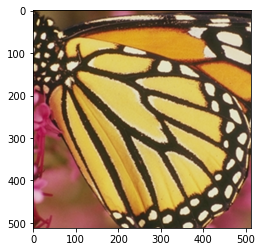

In [36]:
plt.imshow(srcnn.upscaled_image)